# Model Selection

The goal of this notebook is to compare regression algorithms in predicting the changes in the the number of residential units under FAIR Plan policy and, as a secondary target, the total exposure acquired by the program.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_style('whitegrid')

CLEAN_DATA_DIR = Path('../clean_data/')

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'engineered_dataset.csv', index_col=0)
df.sample(3)

,FAIR Plan Units,% FAIR Plan Units,Total Exposure ($),% Change - Claims (Fire and Smoke),% Change - Earned Premiums,% Change - Expiring Policies,% Change - Losses (Fire and Smoke),% Change - New Policies,% Change - Nonrenewed Policies,% Change - Nonrenewed Policies (by Company),...,Growth in Losses to All Disasters 10yr Ratio,Growth in Losses to Fire Disasters 3yr Ratio,Growth in Losses to Fire Disasters 5yr Ratio,Growth in Losses to Fire Disasters 10yr Ratio,Premium to Exposure Ratio,Nonrenewal Rate,Loss Burden per Unit,Loss Burden per Exposure,Premium Adequacy,Renewal Resilience
ZIP Code,,,,,,,,,,,,,,,,,,,,,
90815,19.0,0.001765,12784876.0,-0.039216,0.492595,0.010521,-0.179648,0.066526,0.142388,0.291667,...,-0.059883,-0.089824,-0.089824,-0.059883,3747.879052,0.084040,154.109707,154.109707,24.319552,0.915960
93222,664.0,0.415260,370039823.0,0.000000,0.884699,0.059322,7.053732,0.983471,0.505952,1.148148,...,2.351244,3.526866,3.526866,2.351244,4879.569731,0.156552,210.808630,210.808630,23.146916,0.843448
91307,239.0,0.030059,460884435.0,-0.977543,0.264520,0.023107,-0.985975,0.138235,0.184486,0.314286,...,-0.328658,-0.492988,-0.492988,-0.328658,5870.072192,0.121676,11993.680543,11993.680543,0.489430,0.878324


## Train-test split

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df_train, df_test = train_test_split(
    df,
    test_size=.2,
    random_state=13348,
    shuffle=True
)

## Evaluation metrics

We will use mean squared error (MSE) as our main evaluation metric, but we will also compute RMSE and MAE. 

For model predicting total exposure, we also will include an additional metric called 'global_difference'. This metric calculates, in USD, the absolute difference between the predicted total exposure and the actual one.

In [5]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, root_mean_squared_error as rmse

eval = pd.DataFrame(columns=['mse', 'rmse', 'mae', 'global_diff'])

In [6]:
def calculate_diff(y_true, preds):
    return round(abs((sum(y_true)-sum(preds)) / (1000 * 1000)), 2)

def calculate_metrics(y_true, preds):
    return [mse(y_true, preds), 
            rmse(y_true, preds), 
            mae(y_true, preds), 
            calculate_diff(y_true, preds),
            sum(y_true)]

def plot_metrics(eval):
    assert eval.shape[0] >= 1, ('Evaluation dataframe is empty.')
  
    cols = eval.shape[0] * 2
    eval.plot.bar(y=['rmse', 'mae'], rot=0, figsize=(cols,3), width=.8)

    plt.legend()
    plt.show()

## Feature Selections

Based on our EDA, we selected a series of feature sets to train and benchmark our models, which is described below.

In [7]:
# use the format
# 'feature_set_name': (target, [features]) 
targets = df.columns[:3] #['FAIR Plan Units', '% FAIR Plan Units', 'Total Exposure ($)']
all_features = df.columns[3:]

main_features = ['Renewal Resilience', 'Median Gross Rent ($)',
                'Avg Median Income', 'Zillow Mean Home Value ($)',
                'Fire Disasters 1y', 'Growth in Losses to All Disasters 5yr Ratio',
                'Premium to Exposure Ratio', 'Avg % White-only Pop',
                'Nonrenewal Rate', '% Change - Earned Premiums']

feature_sets = {
    'main_n_fair': (targets[0], main_features),
    'main_%_fair': (targets[1], main_features),
    'main_exposure': (targets[2], main_features),    
}


## Model Specification

In [8]:
# baseline model with the mean
def baseline_model(y_train, y_test):
    mu_y = y_train.mean()
    preds = [mu_y] * len(y_test)
    return calculate_metrics(y_test, preds)

In [9]:
# linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [10]:
# knn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# function to find the best K for a given training set
def best_k(y_train, y_test, X_train, X_test, k_upper=20, plot=True):
    rmses = []
    for k in range(1, k_upper):
        knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        
        # fitting and prediction
        knn_pipe.fit(X_train, y_train)
        preds = knn_pipe.predict(X_test)

        # calculating and saving mse
        rmses.append((k, mse(y_test, preds)))

    # plot graph        
    if plot:
        plt.figure(figsize=(6,4))

        plt.plot(np.array(rmses)[:, 0], np.array(rmses)[:, 1])

        plt.ylabel('MSE')
        plt.xlabel('k')

        plt.show()

    best_k = rmses[int(np.where(np.array(rmses)[:, 1] == np.array(rmses)[:, 1].min())[0])][0]
    return best_k


In [11]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

grad_bost = GradientBoostingRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

In [12]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

## Cross-validation

In [13]:
from sklearn.model_selection import KFold

models = [('Baseline (mean)', None),
          ('Linear Regression', lr), 
          ('kNN - 5', knn), 
          ('Gradient Boosting', grad_bost), 
          ('XGBoost', xgboost)]

kfold = KFold(n_splits = 5)

In [14]:
def run_cross_val(target, features, set=None):
    results = []

    for i, (train_index, test_index) in enumerate(kfold.split(df_train)):
        df_tt = df_train.iloc[train_index]
        df_ho = df_train.iloc[test_index]

        for j, model in enumerate(models):
            if model[0] == 'Baseline (mean)':
                eval = baseline_model(df_tt[target], df_ho[target])
            else:
                model[1].fit(df_tt[features], df_tt[target])
                preds = model[1].predict(df_ho[features])
                eval = calculate_metrics(df_ho[target], preds)

            results.append([set, target, model[0]] + eval)

    return results

In [15]:
# running cross-validation for all feature sets
vals = []

for feature_set, data in feature_sets.items():
    target = data[0]
    features = data[1]

    vals += run_cross_val(target, features, feature_set)

In [16]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

cols = ['Feature Set', 'Target Variable' ,'Model', 'MSE', 'RMSE', 'MAE', 'Global Diff', 'Total Val']
res = pd.DataFrame(vals, columns=cols)

eval = res.groupby(['Feature Set', 'Target Variable' ,'Model']).mean()
eval

MSE  \
Feature Set   Target Variable    Model                                      
main_%_fair   % FAIR Plan Units  Baseline (mean)                    0.010   
                                 Gradient Boosting                  0.003   
                                 Linear Regression                  0.004   
                                 XGBoost                            0.003   
                                 kNN - 5                            0.003   
main_exposure Total Exposure ($) Baseline (mean)   150420645315451296.000   
                                 Gradient Boosting 143605941112916576.000   
                                 Linear Regression 115287937995476864.000   
                                 XGBoost           104410718457640768.000   
                                 kNN - 5           102290269005175232.000   
main_n_fair   FAIR Plan Units    Baseline (mean)               209516.771   
                                 Gradient Boosting             154629.004   
                                 Linear Regression             165035.748   
                                 XGBoost                       118287.675   
                                 kNN - 5                       141133.271   

                                                            RMSE  \
Feature Set   Target Variable    Model                             
main_%_fair   % FAIR Plan Units  Baseline (mean)           0.098   
                                 Gradient Boosting         0.057   
                                 Linear Regression         0.065   
                                 XGBoost                   0.055   
                                 kNN - 5                   0.055   
main_exposure Total Exposure ($) Baseline (mean)   373935605.606   
                                 Gradient Boosting 371010543.524   
                                 Linear Regression 326951135.326   
                                 XGBoost           316697201.757   
                                 kNN - 5           305633224.894   
main_n_fair   FAIR Plan Units    Baseline (mean)         451.798   
                                 Gradient Boosting       389.064   
                                 Linear Regression       399.369   
                                 XGBoost                 339.156   
                                 kNN - 5                 367.983   

                                                             MAE  Global Diff  \
Feature Set   Target Variable    Model                                          
main_%_fair   % FAIR Plan Units  Baseline (mean)           0.057        0.000   
                                 Gradient Boosting         0.030        0.000   
                                 Linear Regression         0.043        0.000   
                                 XGBoost                   0.030        0.000   
                                 kNN - 5                   0.026        0.000   
main_exposure Total Exposure ($) Baseline (mean)   170672553.264     3346.252   
                                 Gradient Boosting 143681497.748     4454.152   
                                 Linear Regression 165896998.749     3278.772   
                                 XGBoost           140388841.923     4414.380   
                                 kNN - 5           124100215.386     4077.498   
main_n_fair   FAIR Plan Units    Baseline (mean)         222.706        0.000   
                                 Gradient Boosting       166.828        0.004   
                                 Linear Regression       211.004        0.002   
                                 XGBoost                 160.905        0.002   
                                 kNN - 5                 160.244        0.006   

                                                         Total Val  
Feature Set   Target Variable    Model                              
main_%_fair   % FAIR Plan Units  Baseline (mean)             8.646  
                  

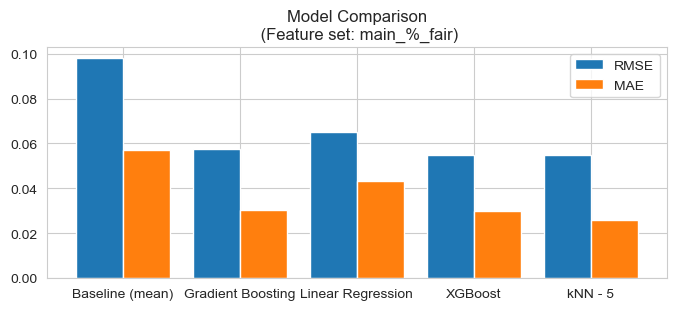

In [17]:
def plot_metrics(feature_set):
    eval.loc[feature_set].droplevel(0).plot.bar(y=['RMSE', 'MAE'], rot=0, width=.8, figsize=(8,3))
    plt.xlabel(None)
    plt.title(f'Model Comparison\n (Feature set: {feature_set})')
    

plot_metrics('main_%_fair')